# Simple Language Models

## Part 1: Autodiff (30 points)

Implement the neural network (called Multi Layered Perceptron) using the JAX autodiff instead of the micrograd library that the presenter uses.

Please pay attention to using the `import jax.numpy as jnp` instead of `import numpy as np` and the `import jax` instead of `import micrograd.engine as engine`.

### Import neccessary libraries

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

JAX needs an random seed to generate the intial values of the weights and biases

In [ ]:
key = random.PRNGKey(0) # random seed
weight_key, bias_key = random.split(key)
print(weight_key, bias_key)

[4146024105  967050713] [2718843009 1272950319]


## Create dataset

In this step, I follow and create the same dataset as the video presenter. However, at the end, convert the type from *np.array* to *jnp.array*.

Later of part 1, the loss values are slightly the same because the `noise` given is too small. We can change it to test.

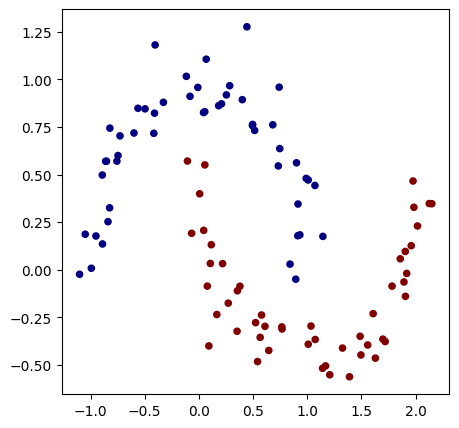

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons, make_blobs
X, Y = make_moons(n_samples=100, noise=0.1)

Y = Y*2 - 1 # make sure y is either 1 or -1
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=Y, s=20, cmap='jet')
X = jnp.array(X) # convert from np to jnp
Y = jnp.array(Y) # convert from np to jnp

### Generate the random weight matrices 

- The number of inputs is equal to the number of `X`'s columns.

- In this assignment, I give the simple neural network 1 hidden layer in the middle, with 16 neurons.

- The number of outputs is equal to the number of `Y`'s columns.

- I create 2 layers so I also create 2 weights and 2 biases.

In [ ]:
input_dims = 2
n_hidden = 16
output_dims = 1

layer1_shape = (n_hidden, input_dims)
layer2_shape = (output_dims, n_hidden)

scale = 0.01

weight1 = scale * jax.random.normal(weight_key, layer1_shape)
bias1 = scale * jax.random.normal(bias_key, (n_hidden,))

weight2 = scale * jax.random.normal(weight_key, layer2_shape)
bias2 = scale * jax.random.normal(bias_key, (output_dims,))

### Algorithm

I locate the parameters of the neural network in a hashmap named `params`.

In [ ]:
params = {
    'w1': weight1,
    'b1': bias1,
    'w2': weight2,
    'b2': bias2,
}

Following the lecture, I build Rectified Linear Unit activation function (ReLUs) to make the problem simple. `ReLUs()` gives a result of 0 if the argument is a non-positive value, and itselfs if the argument is positive.

Then I create function `predict()`, which takes the params hashmap we defined, along with an input to predict the output (a.k.a *y_hat*).

Function `loss()` uses the Mean Squared Error to calculate the mean.

In [ ]:
def ReLUs(x):
    return jnp.maximum(0, x)

def predict(params, input):
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']

    z1 = jnp.dot(w1, input) + b1
    a1 = ReLUs(z1)
    z2 = jnp.dot(w2, a1) + b2
    return z2

def loss(params, input, target):
    prediction = predict(params, input)
    return jnp.mean((prediction - target) ** 2)

### Update the weights

Again, following the lecture and the video, I apply **backpropagation** to update the parameters.

- `grad_fn = grad(loss)` uses function `grad()` from JAX to return the derivative of loss, with respect to the parameters (`w1`, `b1`).

- `gradients = grad_fn(params, input, target)` provides the gradients as a hashmap. Hence, I access the gradient values by `dw1 = gradients['w1']`.

- Finally, the weights are updated by subtracting the gradients from the current weight values.

- At the end, we can see our new weight matrices outputted, and this will become our new `params`.

In [ ]:
learning_rate = 0.01

def update(params, input, target):
    grad_fn = grad(loss) # derivative of function `loss`
    gradients = grad_fn(params, input, target)
    dw1 = gradients['w1']
    db1 = gradients['b1']
    dw2 = gradients['w2']
    db2 = gradients['b2'] # gradient of each  parameter

    new_params = {} # update parameters
    new_params['w1'] = params['w1'] - learning_rate * dw1
    new_params['b1'] = params['b1'] - learning_rate * db1
    new_params['w2'] = params['w2'] - learning_rate * dw2
    new_params['b2'] = params['b2'] - learning_rate * db2

    return new_params

### Training loop

Following the video, I run 100 epochs of training, which means running the update function 100 times in a for loop.

We can change divisor **2** to **1** to print all the loss values.

These values are saved in list `plot_loss` so we can plot a graph later.

In [ ]:
plot_loss = []
for epoch in range(100):
    avg_loss = 0
    for x, y in zip(X, Y):
        params = update(params, x, y)
        new_loss = loss(params, x, y)
        avg_loss += new_loss

    avg_loss = avg_loss / len(X)
    plot_loss.append(avg_loss)
    if epoch % 2 == 0:
        print(f"Step #{epoch}, loss value is {avg_loss}")

Step #0, loss value is 0.2969855070114136
Step #2, loss value is 0.29623326659202576
Step #4, loss value is 0.2954270839691162
Step #6, loss value is 0.29452183842658997
Step #8, loss value is 0.293442964553833
Step #10, loss value is 0.29225412011146545
Step #12, loss value is 0.2911132872104645
Step #14, loss value is 0.289713978767395
Step #16, loss value is 0.28820475935935974
Step #18, loss value is 0.2866147756576538
Step #20, loss value is 0.2850877046585083
Step #22, loss value is 0.2836064398288727
Step #24, loss value is 0.28220364451408386
Step #26, loss value is 0.2806970179080963
Step #28, loss value is 0.2793550193309784
Step #30, loss value is 0.2782365083694458
Step #32, loss value is 0.27683043479919434
Step #34, loss value is 0.275032639503479
Step #36, loss value is 0.2734852433204651
Step #38, loss value is 0.27235281467437744
Step #40, loss value is 0.2713301181793213
Step #42, loss value is 0.27048835158348083
Step #44, loss value is 0.2694031596183777
Step #46, l

### How does the loss change?

Obviously, it gets smaller and smaller, which means more accurate.

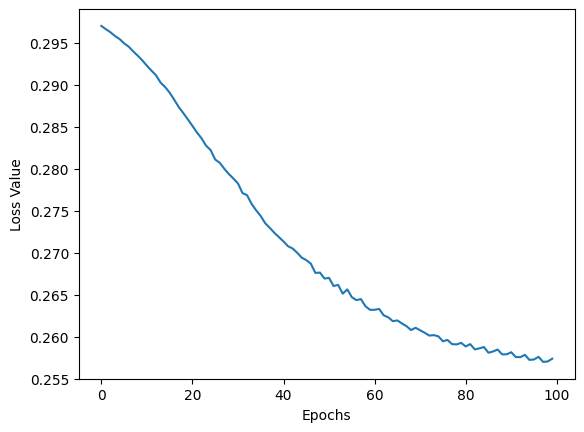

In [ ]:
import matplotlib.pyplot as plt

plt.plot(plot_loss)
plt.xlabel("Epochs")
plt.ylabel("Loss Value")
plt.show()

## Part 2: Bigram Language Model (50 points)

Implement the language model neural network using the JAX and Flax. You are **not** allowed to use `torch` or `TF2`. 


### Import neccessary libraries

In [70]:
import pandas as pd
import jax.numpy as jnp # required
from jax import random # required
import flax # required

### Upload dataset

- Download dataset `surnames.csv` from [Kaggle](https://www.kaggle.com/datasets/fivethirtyeight/fivethirtyeight-most-common-name-dataset?select=surnames.csv)

- Use `open('surnames.csv', 'r')` and `open('names.txt', 'w')` to remove unneccessary columns.

- New dataset is created and save in *names.txt* and we use this dataset as a textfile.

In [71]:
infile = open('names.txt', 'r')
outfile = open('surnames.txt', 'w')
for line in infile:
    lst = line.split()
    outfile.write(lst[0])
    outfile.write('\n')

df = open('names.txt', 'r').read().splitlines()
print(len(df))

32033


### Select bi-characters

- In this code, we use 2 characters to predict the next character.

- `b` is a hashmap containing the frequencies of all pairs of characters that exist from the dataset.

- Then, sort the hashmap, which is optional.

In [83]:
b = {}

for w in df:
    chs = ['<S>'] + list(w) + ['<E>']
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram,0) + 1

In [84]:
dictionary = sorted(b.items(), key = lambda kv: -kv[1])
print(dictionary)

[(('n', '<E>'), 6763), (('a', '<E>'), 6640), (('a', 'n'), 5438), (('<S>', 'a'), 4410), (('e', '<E>'), 3983), (('a', 'r'), 3264), (('e', 'l'), 3248), (('r', 'i'), 3033), (('n', 'a'), 2977), (('<S>', 'k'), 2963), (('l', 'e'), 2921), (('e', 'n'), 2675), (('l', 'a'), 2623), (('m', 'a'), 2590), (('<S>', 'm'), 2538), (('a', 'l'), 2528), (('i', '<E>'), 2489), (('l', 'i'), 2480), (('i', 'a'), 2445), (('<S>', 'j'), 2422), (('o', 'n'), 2411), (('h', '<E>'), 2409), (('r', 'a'), 2356), (('a', 'h'), 2332), (('h', 'a'), 2244), (('y', 'a'), 2143), (('i', 'n'), 2126), (('<S>', 's'), 2055), (('a', 'y'), 2050), (('y', '<E>'), 2007), (('e', 'r'), 1958), (('n', 'n'), 1906), (('y', 'n'), 1826), (('k', 'a'), 1731), (('n', 'i'), 1725), (('r', 'e'), 1697), (('<S>', 'd'), 1690), (('i', 'e'), 1653), (('a', 'i'), 1650), (('<S>', 'r'), 1639), (('a', 'm'), 1634), (('l', 'y'), 1588), (('<S>', 'l'), 1572), (('<S>', 'c'), 1542), (('<S>', 'e'), 1531), (('j', 'a'), 1473), (('r', '<E>'), 1377), (('n', 'e'), 1359), (('l'

Use `matplotlib` to display the frequency hashmap

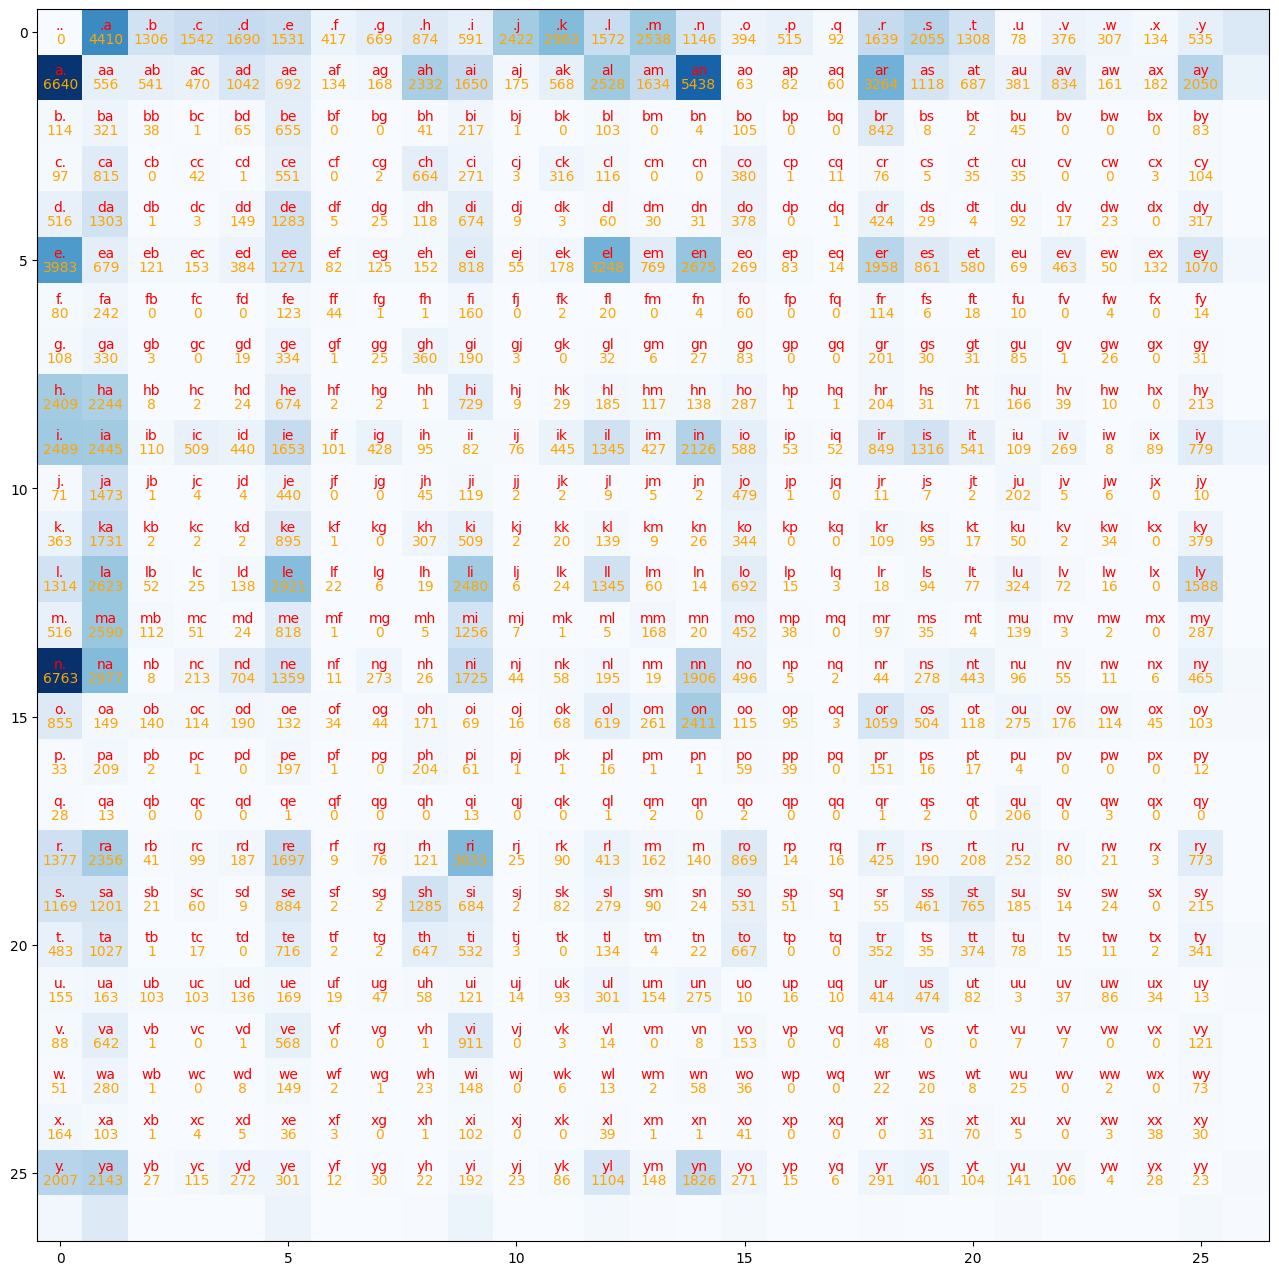

In [75]:
from flax import linen as nn
import jax.numpy as jnp
from jax import device_get

zeros_tensor = jnp.zeros((27, 27), dtype=jnp.int32)

chars = sorted(list(set(''.join(df))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

for w in df:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        zeros_tensor = zeros_tensor.at[ix1, ix2].add(1)

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(16,16))
plt.imshow(device_get(zeros_tensor), cmap='Blues')
for i in range(26):
    for j in range(26):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='red')
        plt.text(j, i, zeros_tensor[i, j].item(), ha="center", va="top", color='orange')

### Building the model

- Next I build the model by using `jax.random.categorical`. The parameter `logits` will change the value of `ix` so we receive a different letter.

- The `logits` applies the **Negative Log Likelihood** (using JAX).

In [85]:
import jax
P = (zeros_tensor + 1).astype(jnp.float32)
P /= P.sum(1, keepdims=True)

rng = jax.random.PRNGKey(2147483647)

for i in range(5):
    out = []
    ix = 0
    max_length = 5  # maximum length of generated sentence
    while len(out) < max_length:
        p = P[ix]
        logits = jnp.log(p)
        ix = jax.random.categorical(rng,logits, shape=(1,)).item()
        token = itos[ix]
        if token == '<eos>':
            break
        out.append(token)
    print(''.join(out))

rerer
rerer
rerer
rerer
rerer


**However**, lookig at the ouputs, it is obvious that the model is wrong. The reason is: I should build a model that includes **ReLUs**, **predict**, **loss**, and **update**. HERE WE GO.

In [86]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(df))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


### Build the dataset

In [87]:
block_size = 3 # number of characters we take to predict the next character

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = jnp.array(X) # convert to JAX
    Y = jnp.array(Y) # convert to JAX
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(df)
n1 = int(0.8*len(df))
n2 = int(0.9*len(df))

Xtr, Ytr = build_dataset(df[:n1])
Xdev, Ydev = build_dataset(df[n1:n2])
Xte, Yte = build_dataset(df[n2:])

(182625, 3) (182625,)
(22655, 3) (22655,)
(22866, 3) (22866,)


### Create parameters

Similar as Part 1, we have 2 layers. So we declare 2 sets of weight and bias

In [89]:
import jax
rng = jax.random.PRNGKey(2147483647)
C_shape = (27, 10)
W1_shape = (30, 200)
b1_shape = (200,)
W2_shape = (200, 27)
b2_shape = (27,)

C = jax.random.normal(rng, C_shape)
W1 = jax.random.normal(rng, W1_shape)
b1 = jax.random.normal(rng, b1_shape)
W2 = jax.random.normal(rng, W2_shape)
b2 = jax.random.normal(rng, b2_shape)

# Define the parameters as a list of JAX arrays
parameters = [C, W1, b1, W2, b2]
print("Total number of neurons:", sum(jnp.size(p) for p in parameters))
params = {
    'w1': W1,
    'b1': b1,
    'w2': W2,
    'b2': b2,
}

Total number of neurons: 11897


In [90]:
def ReLUs(x):
    return jnp.maximum(0, x)

def predict(params, input):
    w1 = params['w1']
    b1 = params['b1']
    w2 = params['w2']
    b2 = params['b2']

    hidden = jnp.dot(w1, input) + b1
    a1 = ReLUs(hidden)
    output = jnp.dot(w2, a1) + b2
    return output

def loss(params, input, target): # Mean Squared Error
    prediction = predict(params, input)
    return jnp.mean((prediction - target) ** 2)

In [91]:
learning_rate = 0.01

def update(params, input, target):
    grad_fn = jax.grad(loss) # derivative of function `loss`
    gradients = grad_fn(params, input, target)
    dw1 = gradients['w1']
    db1 = gradients['b1']
    dw2 = gradients['w2']
    db2 = gradients['b2'] # gradient of each  parameter

    new_params = {} # update parameters
    new_params['w1'] = params['w1'] - learning_rate * dw1
    new_params['b1'] = params['b1'] - learning_rate * db1
    new_params['w2'] = params['w2'] - learning_rate * dw2
    new_params['b2'] = params['b2'] - learning_rate * db2

    return new_params

After that, following the code from the 2nd video, we build a training loop.

- `ix` is a random integer to get element from the input `Xtr`. I replicate the code by using JAX.

In [92]:
lossi = []
stepi = []

for i in range(2000):
    # minibatch construct
    ix = jax.random.randint(rng, (32,), 0, Xtr.shape[0])
    
    avg_loss = 0
    x = Xtr[ix]
    y = Ytr[ix]
    params = update(params, x, y)
    avg_loss += loss(params, x, y)

    # track stats
    stepi.append(i)
    lossi.append(loss.log10().item())

    if i % 2 == 0:
        print(f"Step #{i}, loss value is {avg_loss}")

TypeError: ignored

**However**, it gets the error above and I have no idea how to get it done. I'm so sorry TA and Professor for leeting you down. I am stupid for this assignment. This is the very last step and I couldn't get it done. After that, convert from integer to string to print out the predicting words.